In [78]:
import importlib
import emoDB
import ravdess
importlib.reload(emoDB)
importlib.reload(ravdess)
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from emoDB import EmodbDataset
from torch.nn.utils.rnn import pad_sequence
from torch import cuda
import torch.optim as optim
from ravdess import RavdessDataset
from tqdm import tqdm

In [55]:
def emodb_collate_fn(batch):
    waveforms = [item['waveform'] for item in batch]
    sample_rates = [item['sample_rate'] for item in batch]
    emotions = [item['emotion'] for item in batch]

    # Find max length in waveforms
    max_length = max([waveform.size(1) for waveform in waveforms])

    # Pad all waveforms to max_length
    waveforms_padded = []
    for waveform in waveforms:
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        pad_amount = max_length - waveform.size(1)
        waveform_padded = torch.nn.functional.pad(waveform, (0, pad_amount))
        waveforms_padded.append(waveform_padded)
    # Stack everything up
    
    waveforms_padded = torch.stack(waveforms_padded)
    sample_rates = torch.stack([torch.tensor(sr) for sr in sample_rates])
    emotions = torch.stack([torch.tensor(em) for em in emotions])

    # Create attention mask
    #attention_masks_padded = torch.where(waveforms_padded != 0, 1, 0)
    attention_masks_padded = (waveforms_padded != 0)
    return waveforms_padded, sample_rates, emotions, attention_masks_padded

In [59]:
BATCH_SIZE = 8
EMO_CLASSES = 7
RAVDESS_CLASSES = 8

In [87]:
emoDB = EmodbDataset('./emoDB/')

c:\UCLA\cs260\realproject\emoDB.py:36: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['speaker_id', 'code', 'emotion', 'version', 'file'], dtype=np.float32)


In [11]:
from torch.utils.data import random_split

# Let's say you want to use 80% of the data for training, and 20% for testing
emodb_train_size = int(0.8 * len(emoDB))
emodb_test_size = len(emoDB) - emodb_train_size

emodb_train_dataset, emodb_test_dataset = random_split(emoDB, [emodb_train_size, emodb_test_size])


emodb_train_loader = DataLoader(emodb_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn)
emodb_test_loader = DataLoader(emodb_test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn)

In [79]:
ravdess = RavdessDataset('./ravdess/audio_speech_actors_01-24/')

c:\UCLA\cs260\realproject\ravdess.py:38: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['modality', 'vocal_channel', 'emotion', 'intensity', 'statement', 'repetition', 'actor', 'file'], dtype=np.float32)


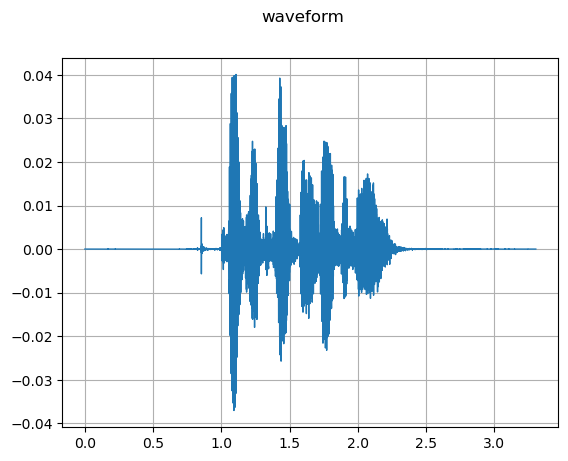

In [85]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
plot_waveform(ravdess[0]['waveform'], ravdess[0]['sample_rate'])

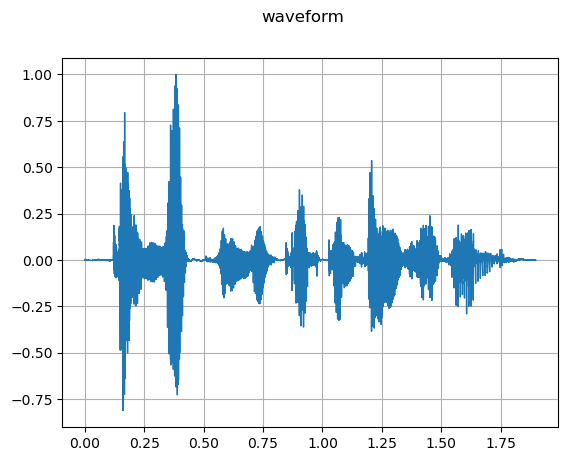

In [88]:
plot_waveform(emoDB[0]['waveform'], emoDB[0]['sample_rate'])

In [89]:
ravdess_train_size = int(0.8 * len(ravdess))
ravdess_test_size = len(ravdess) - ravdess_train_size
ravdess_train, ravdess_test = random_split(ravdess, [ravdess_train_size, ravdess_test_size])
ravdess_train_loader = DataLoader(ravdess_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn)
ravdess_test_loader = DataLoader(ravdess_test, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn) 

In [57]:
def test(model, test_dl):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  total = 0
  correct = 0
  model.to(device)
  model.eval()
  with torch.no_grad():
    for X, rate, y, attention_mask in test_dl:
      X, y, attention_mask = X.to(device), y.to(device), attention_mask.to(device)
      outputs = model.forward(X)
      max, preds = torch.max(outputs.data,1)
      total += y.size(0)
      #print(preds)
      #print(y)
      correct += (preds == y).sum().item()
  accuracy = correct / total

  return accuracy

In [63]:
def train(model, lr, num_epochs, train_dl, test_dl):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        #i = 0
        for X, rate, y, attention_mask in tqdm(train_dl):
            #print(y.shape)
            #y = y.long()
            X, y, attention_mask = X.to(device), y.to(device), attention_mask.to(device)
            optimizer.zero_grad()
            #print(y.shape)
            #print(X.shape)
            #print(attention_mask.shape)
            print(X.shape)
            print(y)
            outputs = model(X)
            print(outputs)
            #print("outputs ", outputs)
            #print("y ", y)
            loss = criterion(outputs, y)
            #print()
            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            """
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    print(f'{name}: gradient max {parameter.grad.data.abs().max()}, gradient min {parameter.grad.data.abs().min()}')
            """
            optimizer.step()

            running_loss += loss.item()
            #print(running_loss)
            _, preds = outputs.max(1)
            total += y.size(0)
            correct += (preds == y).sum().item()

        print(f"Epoch {epoch+1} | Loss: {running_loss / len(train_dl)} | Accuracy: {100.*correct/total}")
        test_accuracy = test(model,test_dl)
        print(f"Test Accuracy: {test_accuracy}")
        torch.cuda.empty_cache()



In [26]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import ScratchModel
emo_transfer_model = TransferModel(EMO_CLASSES)
emo_scratch_model = ScratchModel(EMO_CLASSES)


Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.layers.7.feed_forward.output_dense.weight', 'encoder.layers.11.attention.k_proj.bias', 'encoder.layers.11.attention.k_proj.weight', 'encoder.layers.7.attention.out_proj.weight', 'encoder.layers.8.feed_forward.intermediate_dense.bias', 'encoder.layers.6.attention.out_proj.bias', 'encoder.layers.8.attention.out_proj.weight', 'encoder.layers.9.feed_forward.output_dense.bias', 'encoder.layers.8.feed_forward.intermediate_dense.weight', 'encoder.layers.6.attention.out_proj.weight', 'encoder.layers.10.attention.q_proj.weight', 'encoder.layers.11.attention.q_proj.bias', 'encoder.layers.9.attention.out_proj.bias', 'encoder.layers.8.layer_norm.bias', 'encoder.layers.8.layer_norm.weight', 'encoder.layers.11.feed_forward.output_dense.weight', 'encoder.layers.7.attention.q_proj.weight', 'encoder.layers.9.feed_forward.intermediate_dense.bias', 'encoder.layers.11.attention.v_proj.

In [33]:
lr = 0.0001
num_epochs = 10
train(emo_transfer_model, lr, num_epochs, emodb_train_loader, emodb_test_loader)
final_acc = test(emo_transfer_model, emodb_test_loader)
print(f"final accuracy = {final_acc}")

cuda


100%|██████████| 107/107 [00:11<00:00,  9.16it/s]


Epoch 1 | Loss: 0.573904435542003 | Accuracy: 83.41121495327103
Test Accuracy: 0.8411214953271028


100%|██████████| 107/107 [00:13<00:00,  7.76it/s]


Epoch 2 | Loss: 0.46391217696924353 | Accuracy: 86.21495327102804
Test Accuracy: 0.8317757009345794


100%|██████████| 107/107 [00:11<00:00,  9.03it/s]


Epoch 3 | Loss: 0.4102295006007374 | Accuracy: 89.01869158878505
Test Accuracy: 0.7102803738317757


100%|██████████| 107/107 [00:11<00:00,  9.25it/s]


Epoch 4 | Loss: 0.31383688897373174 | Accuracy: 92.05607476635514
Test Accuracy: 0.7570093457943925


100%|██████████| 107/107 [00:11<00:00,  8.93it/s]


Epoch 5 | Loss: 0.1848487700422721 | Accuracy: 95.79439252336448
Test Accuracy: 0.8691588785046729


100%|██████████| 107/107 [00:10<00:00, 10.35it/s]


Epoch 6 | Loss: 0.2087658777959192 | Accuracy: 94.39252336448598
Test Accuracy: 0.8504672897196262


100%|██████████| 107/107 [00:11<00:00,  8.98it/s]


Epoch 7 | Loss: 0.19557099470925282 | Accuracy: 95.5607476635514
Test Accuracy: 0.8411214953271028


100%|██████████| 107/107 [00:14<00:00,  7.41it/s]


Epoch 8 | Loss: 0.15940856455638133 | Accuracy: 96.72897196261682
Test Accuracy: 0.897196261682243


100%|██████████| 107/107 [00:11<00:00,  9.45it/s]


Epoch 9 | Loss: 0.368476399257518 | Accuracy: 92.99065420560747
Test Accuracy: 0.7383177570093458


100%|██████████| 107/107 [00:15<00:00,  7.02it/s]


Epoch 10 | Loss: 0.26822294731228397 | Accuracy: 95.09345794392523
Test Accuracy: 0.8411214953271028
final accuracy = 0.8504672897196262


In [49]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import ScratchModel

ravdess_transfer_model = TransferModel(RAVDESS_CLASSES)
ravdess_scratch_model = ScratchModel(RAVDESS_CLASSES)



Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.layers.7.feed_forward.output_dense.weight', 'encoder.layers.11.attention.k_proj.bias', 'encoder.layers.11.attention.k_proj.weight', 'encoder.layers.7.attention.out_proj.weight', 'encoder.layers.8.feed_forward.intermediate_dense.bias', 'encoder.layers.6.attention.out_proj.bias', 'encoder.layers.8.attention.out_proj.weight', 'encoder.layers.9.feed_forward.output_dense.bias', 'encoder.layers.8.feed_forward.intermediate_dense.weight', 'encoder.layers.6.attention.out_proj.weight', 'encoder.layers.10.attention.q_proj.weight', 'encoder.layers.11.attention.q_proj.bias', 'encoder.layers.9.attention.out_proj.bias', 'encoder.layers.8.layer_norm.bias', 'encoder.layers.8.layer_norm.weight', 'encoder.layers.11.feed_forward.output_dense.weight', 'encoder.layers.7.attention.q_proj.weight', 'encoder.layers.9.feed_forward.intermediate_dense.bias', 'encoder.layers.11.attention.v_proj.

In [65]:
ravdess_train[0]

{'waveform': tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 'sample_rate': 48000,
 'emotion': 6}

In [64]:
lr = 0.0000001
num_epochs = 20
train(ravdess_transfer_model, lr, num_epochs, ravdess_train_loader, ravdess_test_loader)

cuda


  0%|          | 0/288 [00:00<?, ?it/s]

torch.Size([4, 1, 180981])
tensor([3, 4, 2, 1], device='cuda:0')
tensor([[-0.7976,  0.0969, -0.1312,  0.1392,  0.2028, -0.1297, -0.0201,  0.2962],
        [-0.7949,  0.0958, -0.1297,  0.1412,  0.2001, -0.1298, -0.0205,  0.2967],
        [-0.7985,  0.0981, -0.1314,  0.1397,  0.2031, -0.1303, -0.0195,  0.2974],
        [-0.7951,  0.0962, -0.1277,  0.1376,  0.1992, -0.1318, -0.0197,  0.2980]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


  0%|          | 1/288 [00:05<25:51,  5.41s/it]

torch.Size([4, 1, 180981])
tensor([1, 7, 0, 5], device='cuda:0')
tensor([[-0.7937,  0.0965, -0.1296,  0.1387,  0.2007, -0.1306, -0.0195,  0.2947],
        [-0.7945,  0.0951, -0.1311,  0.1401,  0.2012, -0.1275, -0.0201,  0.2954],
        [-0.7970,  0.0969, -0.1309,  0.1394,  0.2020, -0.1272, -0.0208,  0.2944],
        [-0.7969,  0.0956, -0.1311,  0.1393,  0.2003, -0.1298, -0.0209,  0.2961]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


  0%|          | 1/288 [00:10<49:41, 10.39s/it]


KeyboardInterrupt: 